# Imports

In [1]:
import numpy as np
import pandas as pd
import modin.pandas as md
import dask.dataframe as dd
import perfplot
import matplotlib.pyplot as plt
import psutil

# Setup

## Modin

In [2]:
import os
os.environ["MODIN_ENGINE"] = "ray"

## Dask

In [3]:
ncores = psutil.cpu_count()
npartitions = ncores*2

# Read Data

In [4]:
data = pd.read_csv("../examples/status.csv")
print(data.shape)
data.head()

(71984434, 4)


,station_id,bikes_available,docks_available,time
0,2,2,25,2013/08/29 12:06:01
1,2,2,25,2013/08/29 12:07:01
2,2,2,25,2013/08/29 12:08:01
3,2,2,25,2013/08/29 12:09:01
4,2,2,25,2013/08/29 12:10:01


In [5]:
data["datetime"] = pd.to_datetime(data["time"])
data.head()

,station_id,bikes_available,docks_available,time,datetime
0,2,2,25,2013/08/29 12:06:01,2013-08-29 12:06:01
1,2,2,25,2013/08/29 12:07:01,2013-08-29 12:07:01
2,2,2,25,2013/08/29 12:08:01,2013-08-29 12:08:01
3,2,2,25,2013/08/29 12:09:01,2013-08-29 12:09:01
4,2,2,25,2013/08/29 12:10:01,2013-08-29 12:10:01


# Perfplot

In [251]:
max_k = 28

## Numeric Operations

### Series

In [7]:
def bikes_proportion(x, max_x=np.max(data["bikes_available"])):
    return round(x * 1.0 / max_x, 2)

In [164]:
data.loc[:10, "bikes_available"].apply(bikes_proportion, max_x=np.max(data['bikes_available']))

0     0.07
1     0.07
2     0.07
3     0.07
4     0.07
5     0.07
6     0.07
7     0.07
8     0.07
9     0.07
10    0.07
Name: bikes_available, dtype: float64

In [111]:
numeric_series_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, 'bikes_available'],
    kernels=[
        lambda df: df.apply(bikes_proportion, max_x=np.max(data['bikes_available'])),
        lambda df: md.DataFrame(df).apply(bikes_proportion, max_x=np.max(data['bikes_available']))._to_pandas()["bikes_available"],
        lambda df: dd.from_pandas(df, npartitions=npartitions).map_partitions(bikes_proportion, max_x=np.max(data['bikes_available']), meta=('f8')).compute(scheduler='threads'),
    ],
    labels=['Pandas Apply', 'Modin Apply', 'Dask Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

 67%|██████▋   | 2/3 [00:02<00:01,  1.12s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.14s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.05s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.13s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.11s/it]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋ 

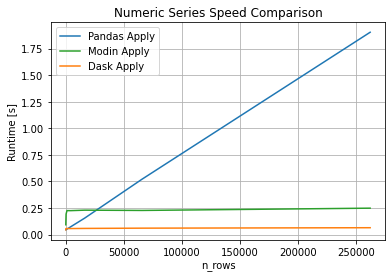

In [112]:
numeric_series_comparison.title = "Numeric Series Speed Comparison"
numeric_series_comparison.xlabel = "n_rows"
numeric_series_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

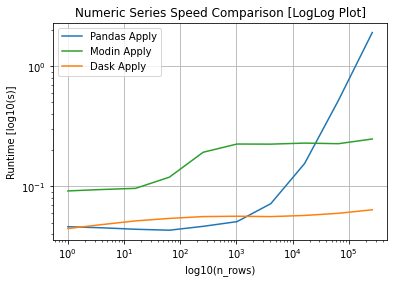

In [113]:
numeric_series_comparison.xlabel = 'log10(n_rows)'
numeric_series_comparison.title = 'Numeric Series Speed Comparison [LogLog Plot]'
numeric_series_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

### DataFrame (Axis 0)

In [130]:
def square(x):
    return x**2

In [161]:
data.loc[:10, ['bikes_available', 'docks_available']].apply(square, axis=0)

,bikes_available,docks_available
0,4,625
1,4,625
2,4,625
3,4,625
4,4,625
5,4,625
6,4,625
7,4,625
8,4,625
9,4,625


In [135]:
# Dask doesn't support axis=0 applies
numeric_df_axis0_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, ['bikes_available', 'docks_available']],
    kernels=[
        lambda df: df.apply(square, axis=0),
        lambda df: md.DataFrame(df).apply(square, axis=0)._to_pandas(),
    ],
    labels=['Pandas Apply', 'Modin Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

 50%|█████     | 1/2 [00:00<00:00,  1.59it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

100%|██████████| 10/10 [00:20<00:00,  2.07s/it]


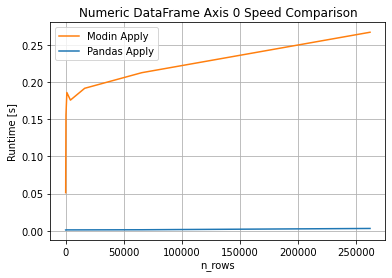

In [136]:
numeric_df_axis0_comparison.title = "Numeric DataFrame Axis 0 Speed Comparison"
numeric_df_axis0_comparison.xlabel = "n_rows"
numeric_df_axis0_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

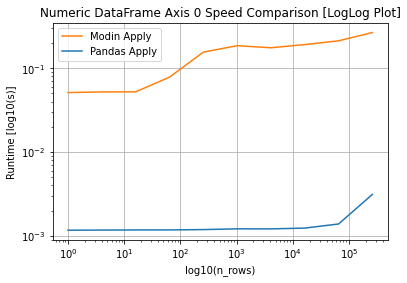

In [137]:
numeric_df_axis0_comparison.xlabel = 'log10(n_rows)'
numeric_df_axis0_comparison.title = 'Numeric DataFrame Axis 0 Speed Comparison [LogLog Plot]'
numeric_df_axis0_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

### DataFrame (Axis 1)

In [26]:
def bikes_to_docks_ratio(row):
    return row["bikes_available"] / row["docks_available"]

In [159]:
data.loc[:10, ["bikes_available", "docks_available"]].apply(bikes_to_docks_ratio, axis=1)

0     0.08
1     0.08
2     0.08
3     0.08
4     0.08
5     0.08
6     0.08
7     0.08
8     0.08
9     0.08
10    0.08
dtype: float64

In [109]:
numeric_df_axis1_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, ['bikes_available', 'docks_available']],
    kernels=[
        lambda df: df.apply(bikes_to_docks_ratio, axis=1),
        lambda df: md.DataFrame(df).apply(bikes_to_docks_ratio, axis=1)._to_pandas()[0],
        lambda df: dd.from_pandas(df, npartitions=npartitions).apply(bikes_to_docks_ratio, axis=1, meta=('f8')).compute(scheduler='threads'),
    ],
    labels=['Pandas Apply', 'Modin Apply', 'Dask Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

 67%|██████▋   | 2/3 [00:01<00:00,  2.04it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.29it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.28it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.15it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.09it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.04s/it]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 67%|██████▋   | 2/3 [00:02<00:01,  1.17s/it]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.


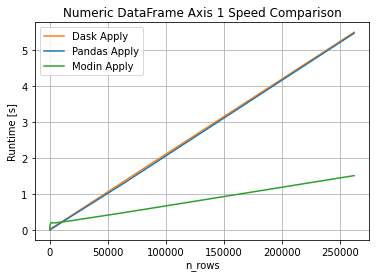

In [114]:
numeric_df_axis1_comparison.title = "Numeric DataFrame Axis 1 Speed Comparison"
numeric_df_axis1_comparison.xlabel = "n_rows"
numeric_df_axis1_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

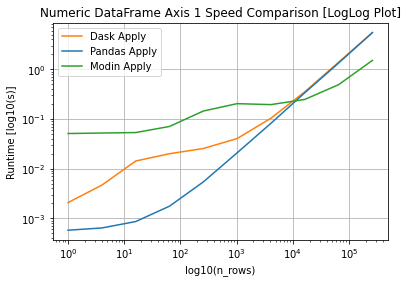

In [115]:
numeric_df_axis1_comparison.xlabel = 'log10(n_rows)'
numeric_df_axis1_comparison.title = 'Numeric DataFrame Axis 1 Speed Comparison [LogLog Plot]'
numeric_df_axis1_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

## String Operations

In [103]:
N_rows = 7000000
str_data = pd.DataFrame([["i want to break free"]] * N_rows, columns=["text"])

In [120]:
def clean_text(text):
    text = text.replace('i want to break free', 'i_want_to_break_free')
    return text + "_from_my_cage"

In [156]:
str_data.iloc[:10].apply(clean_text) 

,text
0,i_want_to_break_free_from_my_cage
1,i_want_to_break_free_from_my_cage
2,i_want_to_break_free_from_my_cage
3,i_want_to_break_free_from_my_cage
4,i_want_to_break_free_from_my_cage
5,i_want_to_break_free_from_my_cage
6,i_want_to_break_free_from_my_cage
7,i_want_to_break_free_from_my_cage
8,i_want_to_break_free_from_my_cage
9,i_want_to_break_free_from_my_cage


### Series

In [121]:
string_series_comparison = perfplot.bench(
    setup=lambda n: str_data.loc[:n, 'text'].astype(str),
    kernels=[
        lambda str_df: str_df.apply(clean_text),
        lambda str_df: md.DataFrame(str_df).apply(clean_text)._to_pandas()["text"],
        lambda str_df: dd.from_pandas(str_df, npartitions=npartitions).map_partitions(clean_text, meta=('O')).compute(scheduler='threads'),
    ],
    labels=['Pandas Apply', 'Modin Apply', 'Dask Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

 67%|██████▋   | 2/3 [00:01<00:00,  1.42it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.32it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.21it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.79it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.10it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.12it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋   | 2/3 [00:01<00:00,  1.18it/s]UserWarning: Distributing <class 'pandas.core.series.Series'> object. This may take some time.

 67%|██████▋ 

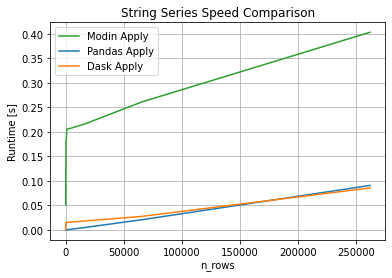

In [122]:
string_series_comparison.title = "String Series Speed Comparison"
string_series_comparison.xlabel = "n_rows"
string_series_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

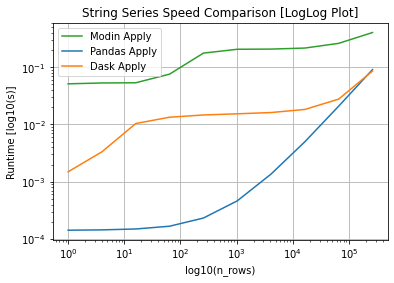

In [123]:
string_series_comparison.xlabel = 'log10(n_rows)'
string_series_comparison.title = 'String Series Speed Comparison [LogLog Plot]'
string_series_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

### DataFrame (Axis 0)

In [186]:
def values(x):
    return f"Values: {', '.join([str(v) for v in x])}"

In [187]:
data.iloc[:10].apply(values, axis=0)

station_id                      Values: 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
bikes_available                 Values: 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
docks_available       Values: 25, 25, 25, 25, 25, 25, 25, 25, 25, 25
time               Values: 2013/08/29 12:06:01, 2013/08/29 12:07:...
datetime           Values: 2013-08-29 12:06:01, 2013-08-29 12:07:...
dtype: object

In [189]:
# Dask doesn't support axis=0 applies
string_df_axis0_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n].astype(str),
    kernels=[
        lambda df: df.apply(values, axis=0),
        lambda df: md.DataFrame(df).apply(values, axis=0)._to_pandas(),
    ],
    labels=['Pandas Apply', 'Modin Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

100%|██████████| 10/10 [00:25<00:00,  2.53s/it]


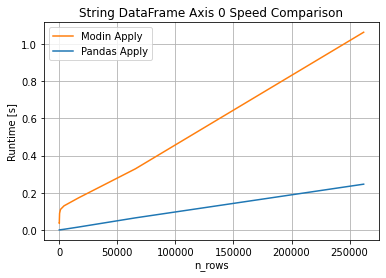

In [190]:
string_df_axis0_comparison.title = "String DataFrame Axis 0 Speed Comparison"
string_df_axis0_comparison.xlabel = "n_rows"
string_df_axis0_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

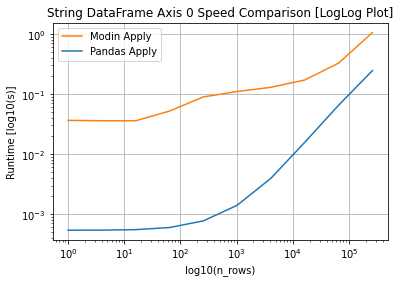

In [191]:
string_df_axis0_comparison.xlabel = 'log10(n_rows)'
string_df_axis0_comparison.title = 'String DataFrame Axis 0 Speed Comparison [LogLog Plot]'
string_df_axis0_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

### DataFrame (Axis 1)

In [181]:
def row_to_str(row):
    return ", ".join([str(c) for c in row])

In [183]:
data.iloc[:10].apply(row_to_str, axis=1)

0    2, 2, 25, 2013/08/29 12:06:01, 2013-08-29 12:0...
1    2, 2, 25, 2013/08/29 12:07:01, 2013-08-29 12:0...
2    2, 2, 25, 2013/08/29 12:08:01, 2013-08-29 12:0...
3    2, 2, 25, 2013/08/29 12:09:01, 2013-08-29 12:0...
4    2, 2, 25, 2013/08/29 12:10:01, 2013-08-29 12:1...
5    2, 2, 25, 2013/08/29 12:11:01, 2013-08-29 12:1...
6    2, 2, 25, 2013/08/29 12:12:01, 2013-08-29 12:1...
7    2, 2, 25, 2013/08/29 12:13:01, 2013-08-29 12:1...
8    2, 2, 25, 2013/08/29 12:15:01, 2013-08-29 12:1...
9    2, 2, 25, 2013/08/29 12:16:02, 2013-08-29 12:1...
dtype: object

In [153]:
string_df_axis1_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n].astype(str),
    kernels=[
        lambda df: df.apply(row_to_str, axis=1),
        lambda df: md.DataFrame(df).apply(row_to_str, axis=1)._to_pandas(),
        lambda df: dd.from_pandas(df, npartitions=npartitions).apply(row_to_str, axis=1, meta=('O')).compute(scheduler='threads'),
    ],
    labels=['Pandas Apply', 'Modin Apply', 'Dask Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

 33%|███▎      | 1/3 [00:00<00:01,  1.29it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.20it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.01it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.16it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.05it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.06it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:01<00:02,  1.02s/it]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.


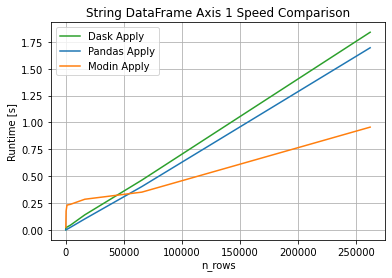

In [154]:
string_df_axis1_comparison.title = "String DataFrame Axis 1 Speed Comparison"
string_df_axis1_comparison.xlabel = "n_rows"
string_df_axis1_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

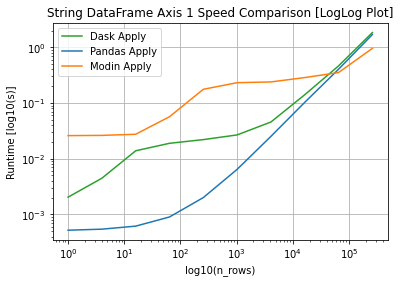

In [155]:
string_df_axis1_comparison.xlabel = 'log10(n_rows)'
string_df_axis1_comparison.title = 'String DataFrame Axis 1 Speed Comparison [LogLog Plot]'
string_df_axis1_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")

## Groupby Operations

### Numeric

In [232]:
def summary_stats(x):
    return x["bikes_available"].min(), x["bikes_available"].max(), x["bikes_available"].mean(), x["bikes_available"].std()

In [233]:
data.loc[:10, ["station_id", "bikes_available"]].groupby("station_id").apply(summary_stats)

station_id
2    (2, 2, 2.0, 0.0)
dtype: object

In [239]:
numeric_groupby_comparison = perfplot.bench(
    setup=lambda n: data.loc[:n, ['station_id', 'bikes_available']],
    kernels=[
        lambda df: df.groupby("station_id").apply(summary_stats),
        lambda df: md.DataFrame(df).groupby("station_id").apply(summary_stats)._to_pandas().T[0],
        lambda df: dd.from_pandas(df, npartitions=npartitions).groupby("station_id").apply(summary_stats, meta=('f8')).compute(scheduler='threads'),
    ],
    labels=['Pandas Apply', 'Modin Apply', 'Dask Apply'],
    n_range=[2**k for k in range(0, max_k, 2)],
    xlabel='n_rows',
    equality_check=lambda left, right: left.equals(right)
)

 33%|███▎      | 1/3 [00:00<00:01,  1.15it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.17it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.21it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.11it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.59it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.87it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.

 33%|███▎      | 1/3 [00:00<00:01,  1.18it/s]UserWarning: Distributing <class 'pandas.core.frame.DataFrame'> object. This may take some time.


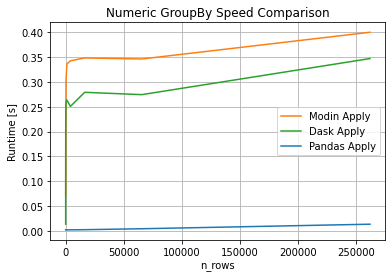

In [240]:
numeric_groupby_comparison.title = "Numeric GroupBy Speed Comparison"
numeric_groupby_comparison.xlabel = "n_rows"
numeric_groupby_comparison.plot(logx=False, logy=False)

Text(0, 0.5, 'Runtime [log10(s)]')

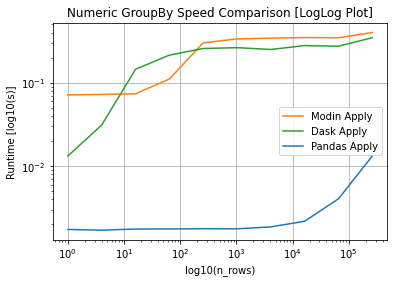

In [241]:
numeric_groupby_comparison.xlabel = 'log10(n_rows)'
numeric_groupby_comparison.title = 'Numeric GroupBy Speed Comparison [LogLog Plot]'
numeric_groupby_comparison.plot(logx=True, logy=True, time_unit='s')
plt.ylabel("Runtime [log10(s)]")